<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр batch_size, почему вы так считаете?

Ответ:

Чем больше батчи, тем меньше шагов будет в одну эпоху - займет меньше времени. Если мы имеем заданный таргет и слишком большой батч сайз, то мы можем получить слишком большие шаги и перепрыгивать таргет

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Чем больше батчи, тем меньше шагов будет в одну эпоху - займет меньше времени. Если мы имеем заданный таргет и слишком большой батч сайз, то мы можем получить слишком большие шаги и перепрыгивать таргет.![nn_1.jpg](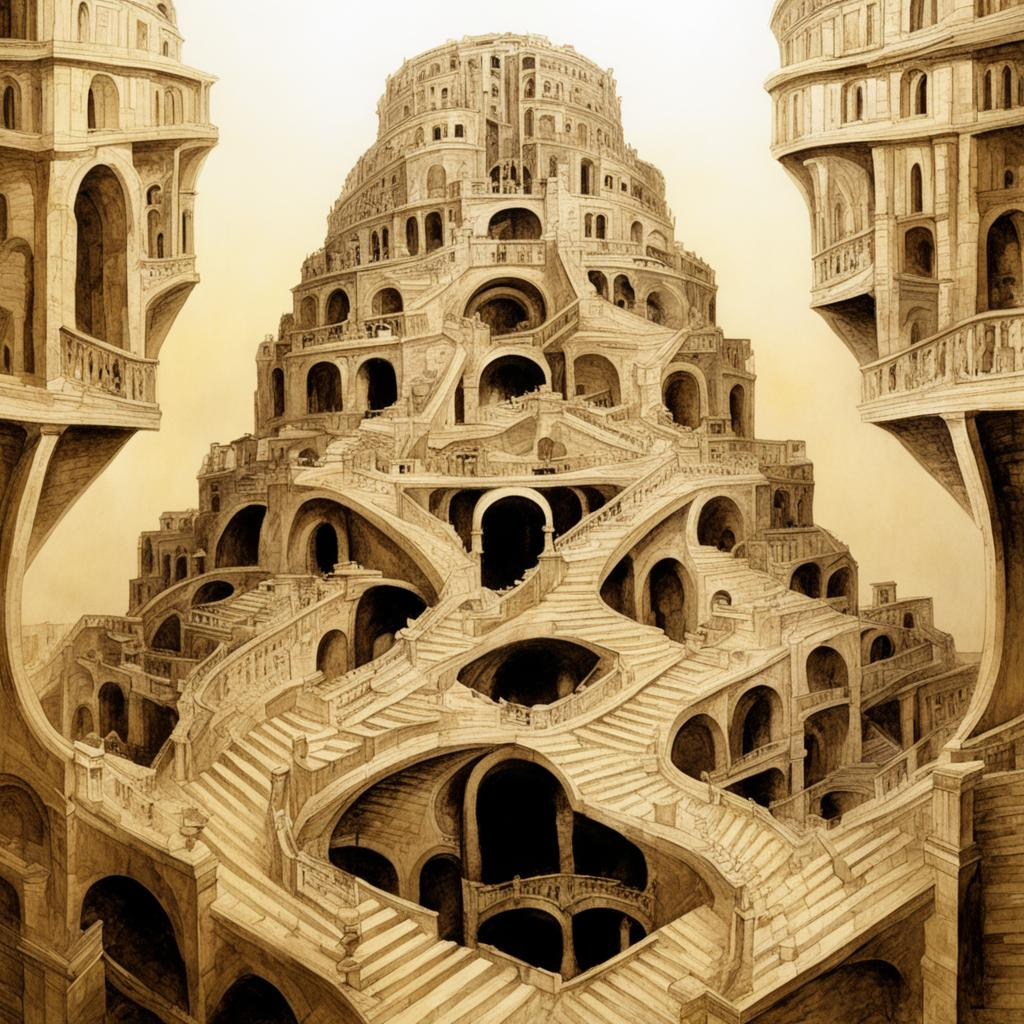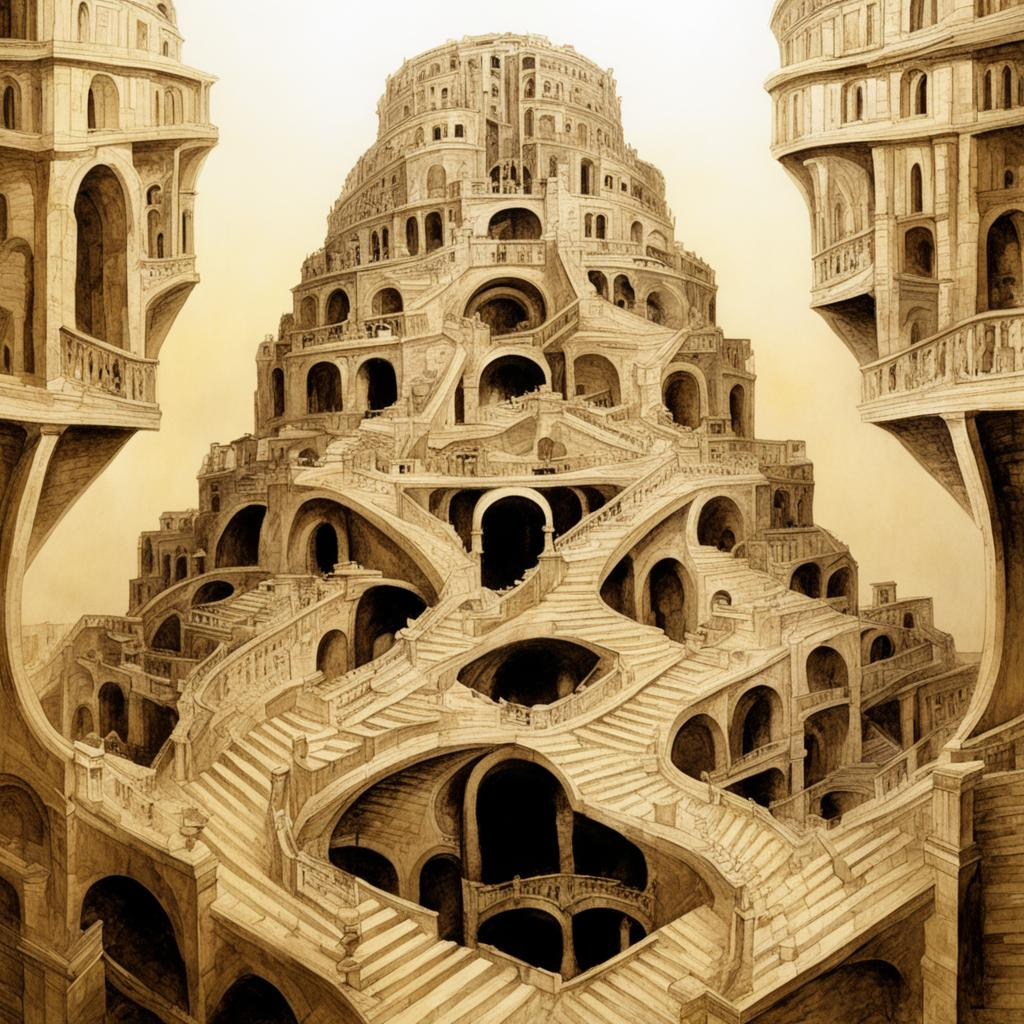)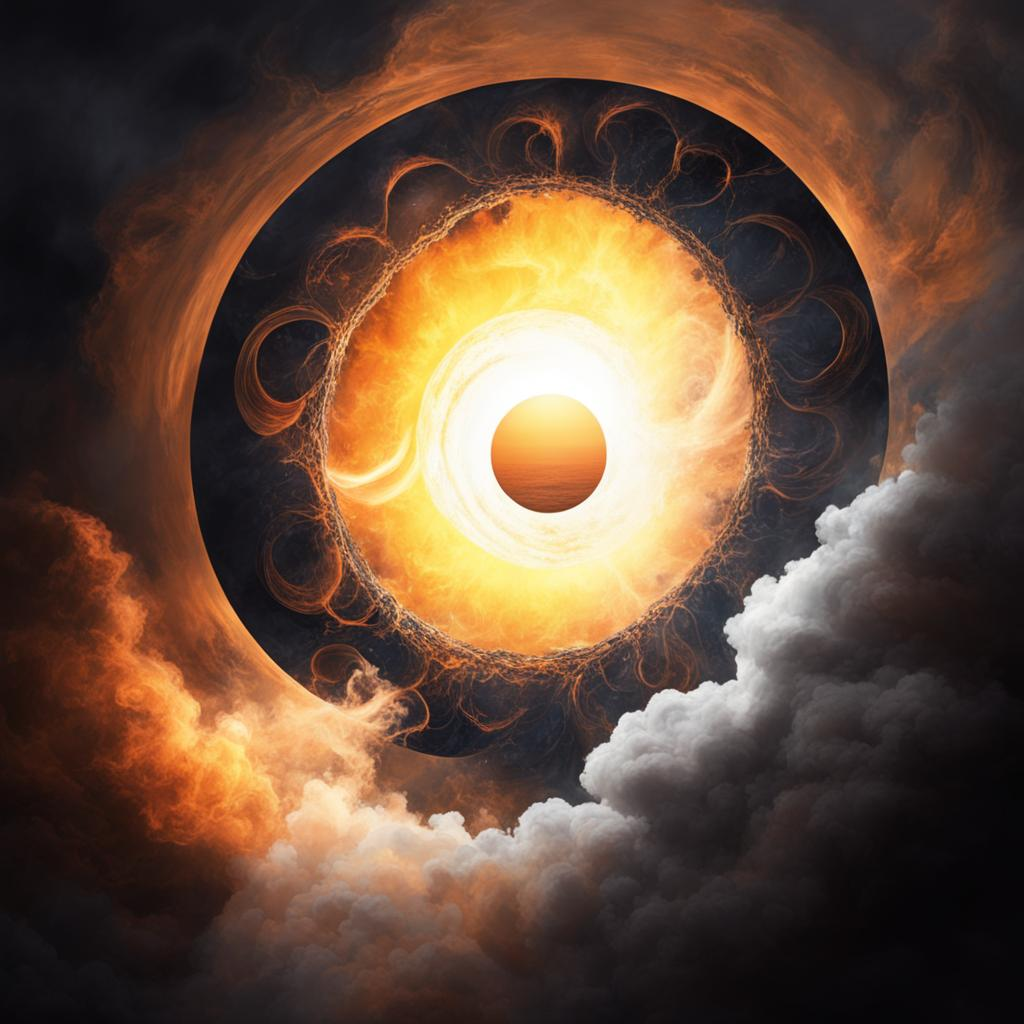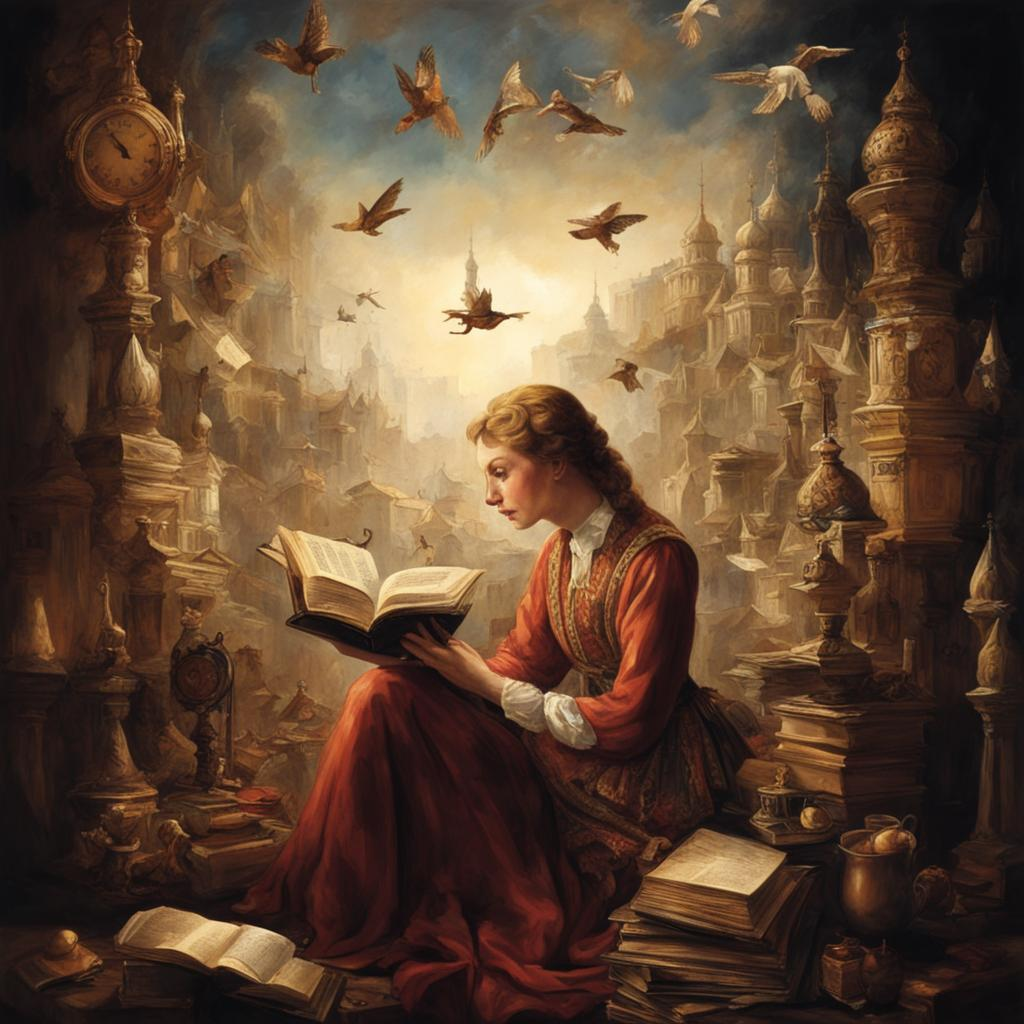

Посмотрим на какую-нибудь картинку:

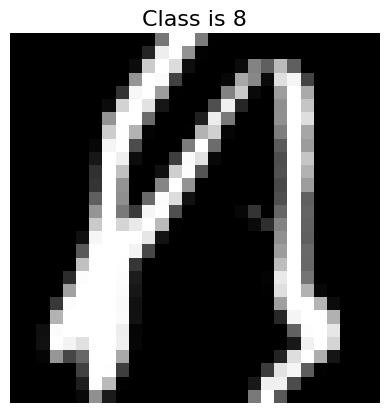

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





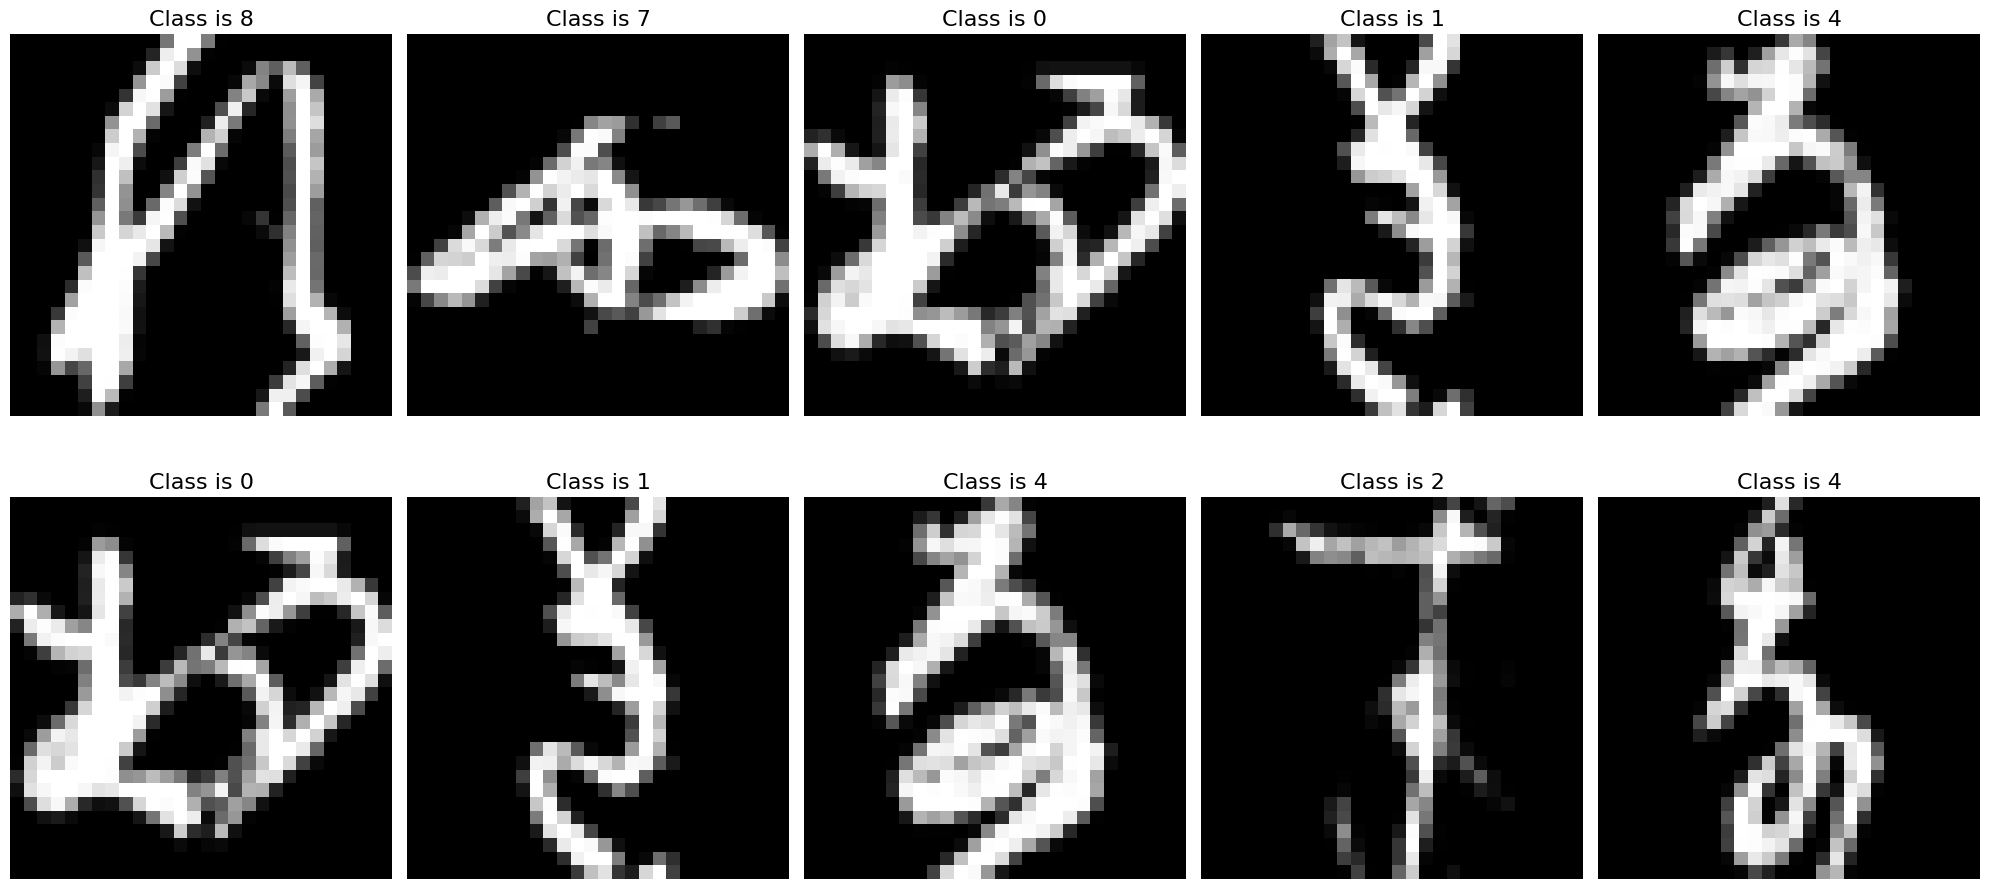

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # Создаем сетку 5x2

for i in range(2):
    for j in range(5):
        index = i * 2 + j  # Вычисляем индекс для выбора изображения из набора данных
        axs[i, j].imshow(trainset[index][0].view(28, 28).numpy(), cmap="gray")
        axs[i, j].axis("off")
        axs[i, j].set_title(f"Class is {trainset[index][1]}", fontsize=16)

plt.tight_layout()
plt.show()


### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        logits = x

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [22]:
# Смещений 3
# Весов
(28 * 28 * 256) + (256 * 128) + (128 * 10)

234752

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [23]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [24]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на

---

тестовой выборке удалось получить?

In [25]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.9202
Epoch=2 loss=0.4453
Epoch=3 loss=0.3456
Epoch=4 loss=0.2862
Epoch=5 loss=0.2463
Epoch=6 loss=0.2141
Epoch=7 loss=0.1877
Epoch=8 loss=0.1655
Epoch=9 loss=0.1461
Epoch=10 loss=0.1294


In [26]:
get_accuracy(fc_net, testloader)

0.8724

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [29]:
mean = 0.0
for images, _ in trainloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(trainloader.dataset)

var = 0.0
for images, _ in trainloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(trainloader.dataset)*28*28))
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([0.1918]) tensor([0.3483])


In [30]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [31]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.6924
Epoch=2 loss=0.3059
Epoch=3 loss=0.2259
Epoch=4 loss=0.1765
Epoch=5 loss=0.1417
Epoch=6 loss=0.1137
Epoch=7 loss=0.0932
Epoch=8 loss=0.0758
Epoch=9 loss=0.0624
Epoch=10 loss=0.0503


In [32]:
get_accuracy(fc_net, testloader)

0.8963

Как изменилась `accuracy` после нормализации?

Увеличилась на 0.02

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [34]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self, activation_function):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation_function = activation_function

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation_function(x)
        x = self.fc2(x)
        x = self.activation_function(x)
        x = self.fc3(x)
        return x

In [47]:
fc_net_gelu = FCNet(nn.GELU())
optimizer_gelu = torch.optim.Adam(fc_net_gelu.parameters(), lr=3e-4)
fc_net_sigmoid = FCNet(nn.Sigmoid())
optimizer_sigmoid = torch.optim.Adam(fc_net_sigmoid.parameters(), lr=3e-4)
fc_net_tanh = FCNet(nn.Tanh())
optimizer_tanh = torch.optim.Adam(fc_net_tanh.parameters(), lr=3e-4)
loss_function = nn.CrossEntropyLoss()
lr = 0.001


In [49]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_gelu.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_gelu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_gelu.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.6538
Epoch=2 loss=0.2832
Epoch=3 loss=0.2063
Epoch=4 loss=0.1574
Epoch=5 loss=0.1241
Epoch=6 loss=0.0990
Epoch=7 loss=0.0791
Epoch=8 loss=0.0634
Epoch=9 loss=0.0506
Epoch=10 loss=0.0394
CPU times: user 41.1 s, sys: 3.29 s, total: 44.4 s
Wall time: 2min 53s


In [52]:
get_accuracy(fc_net_gelu, testloader)

0.902

In [50]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_sigmoid.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_sigmoid(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_sigmoid.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=1.5931
Epoch=2 loss=0.7710
Epoch=3 loss=0.5550
Epoch=4 loss=0.4505
Epoch=5 loss=0.3792
Epoch=6 loss=0.3231
Epoch=7 loss=0.2781
Epoch=8 loss=0.2420
Epoch=9 loss=0.2119
Epoch=10 loss=0.1874
CPU times: user 38.8 s, sys: 3.21 s, total: 42 s
Wall time: 2min 46s


In [51]:
get_accuracy(fc_net_sigmoid, testloader)

0.8597

In [53]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_tanh.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_tanh(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_tanh.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.7914
Epoch=2 loss=0.3859
Epoch=3 loss=0.2587
Epoch=4 loss=0.1863
Epoch=5 loss=0.1387
Epoch=6 loss=0.1035
Epoch=7 loss=0.0786
Epoch=8 loss=0.0580
Epoch=9 loss=0.0433
Epoch=10 loss=0.0317
CPU times: user 39.7 s, sys: 3.33 s, total: 43 s
Wall time: 2min 45s


In [54]:
get_accuracy(fc_net_tanh, testloader)

0.8946

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

In [55]:
# gelu

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [56]:
fc_net_gelu = FCNet(nn.GELU())
optimizer_gelu = torch.optim.Adam(fc_net_gelu.parameters(), lr=3e-4)

In [63]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_gelu.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_gelu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_gelu.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.3698
Epoch=2 loss=0.3672
Epoch=3 loss=0.3635
Epoch=4 loss=0.3615
Epoch=5 loss=0.3580
Epoch=6 loss=0.3555
Epoch=7 loss=0.3534
Epoch=8 loss=0.3510
Epoch=9 loss=0.3483
Epoch=10 loss=0.3459
CPU times: user 39.1 s, sys: 3.2 s, total: 42.3 s
Wall time: 3min 16s


In [64]:
get_accuracy(fc_net_gelu, testloader)

0.7819

In [57]:
fc_net_gelu = FCNet(nn.GELU())
optimizer_gelu = torch.optim.RMSprop(fc_net_gelu.parameters(), lr=3e-4)

In [65]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_gelu.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_gelu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_gelu.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.3438
Epoch=2 loss=0.3415
Epoch=3 loss=0.3392
Epoch=4 loss=0.3376
Epoch=5 loss=0.3354
Epoch=6 loss=0.3335
Epoch=7 loss=0.3316
Epoch=8 loss=0.3298
Epoch=9 loss=0.3277
Epoch=10 loss=0.3257
CPU times: user 38.5 s, sys: 3.26 s, total: 41.8 s
Wall time: 3min 6s


In [66]:
get_accuracy(fc_net_gelu, testloader)

0.791

In [58]:
fc_net_gelu = FCNet(nn.GELU())
optimizer_gelu = torch.optim.Adagrad(fc_net_gelu.parameters(), lr=3e-4)

In [61]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_gelu.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_gelu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_gelu.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.4083
Epoch=2 loss=0.4036
Epoch=3 loss=0.3988
Epoch=4 loss=0.3948
Epoch=5 loss=0.3907
Epoch=6 loss=0.3867
Epoch=7 loss=0.3831
Epoch=8 loss=0.3795
Epoch=9 loss=0.3759
Epoch=10 loss=0.3727
CPU times: user 38.5 s, sys: 3.27 s, total: 41.8 s
Wall time: 3min 2s


In [62]:
get_accuracy(fc_net_gelu, testloader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.7702

Лучшим оптимизатором оказался -

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [71]:
fc_net_relu = FCNet(nn.ReLU())
optimizer_relu = torch.optim.RMSprop(fc_net_relu.parameters(), lr=3e-4)

In [72]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_relu.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_relu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_relu.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch=1 loss=0.4696
Epoch=2 loss=0.2576
Epoch=3 loss=0.1941
Epoch=4 loss=0.1521
Epoch=5 loss=0.1224
Epoch=6 loss=0.0988
Epoch=7 loss=0.0802
Epoch=8 loss=0.0654
Epoch=9 loss=0.0523
Epoch=10 loss=0.0425
CPU times: user 35.9 s, sys: 3.34 s, total: 39.3 s
Wall time: 2min 45s


In [73]:
get_accuracy(fc_net_relu, testloader)

0.8939

In [80]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.max(torch.zeros_like(x), x)



In [83]:
fc_net_custom_relu = FCNet(CustomReLU())
optimizer_custom_relu = torch.optim.RMSprop(fc_net_custom_relu.parameters(), lr=3e-4)


In [84]:
%%time
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer_custom_relu.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net_custom_relu(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer_custom_relu.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.4715
Epoch=2 loss=0.2568
Epoch=3 loss=0.1946
Epoch=4 loss=0.1526
Epoch=5 loss=0.1232
Epoch=6 loss=0.1008
Epoch=7 loss=0.0821
Epoch=8 loss=0.0666
Epoch=9 loss=0.0544
Epoch=10 loss=0.0439
CPU times: user 39.3 s, sys: 3.36 s, total: 42.6 s
Wall time: 2min 46s


In [85]:
get_accuracy(fc_net_custom_relu, testloader)

0.8923

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

Точность отличается на 0.007 - модели почти одинаковы.

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.


Запрос:
Солнечное затмение и от него по спирали расходится дым

(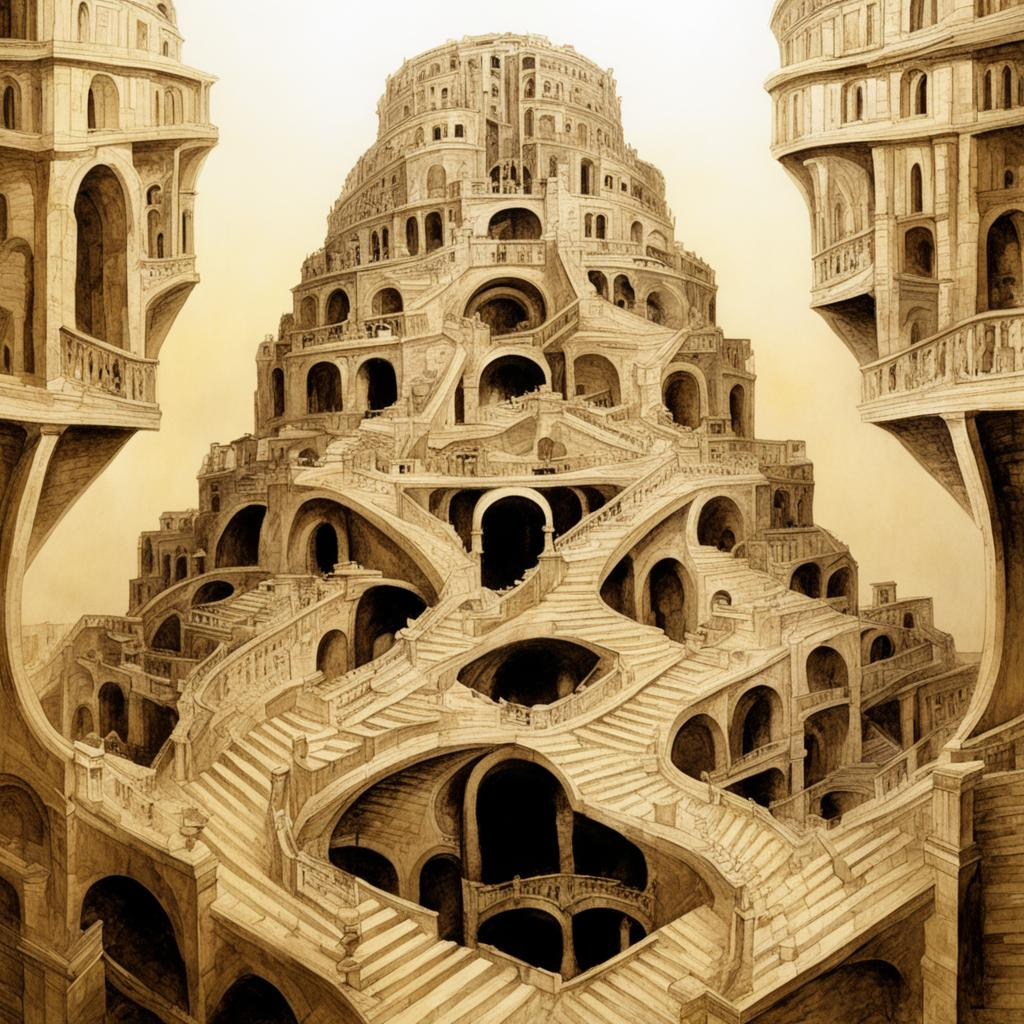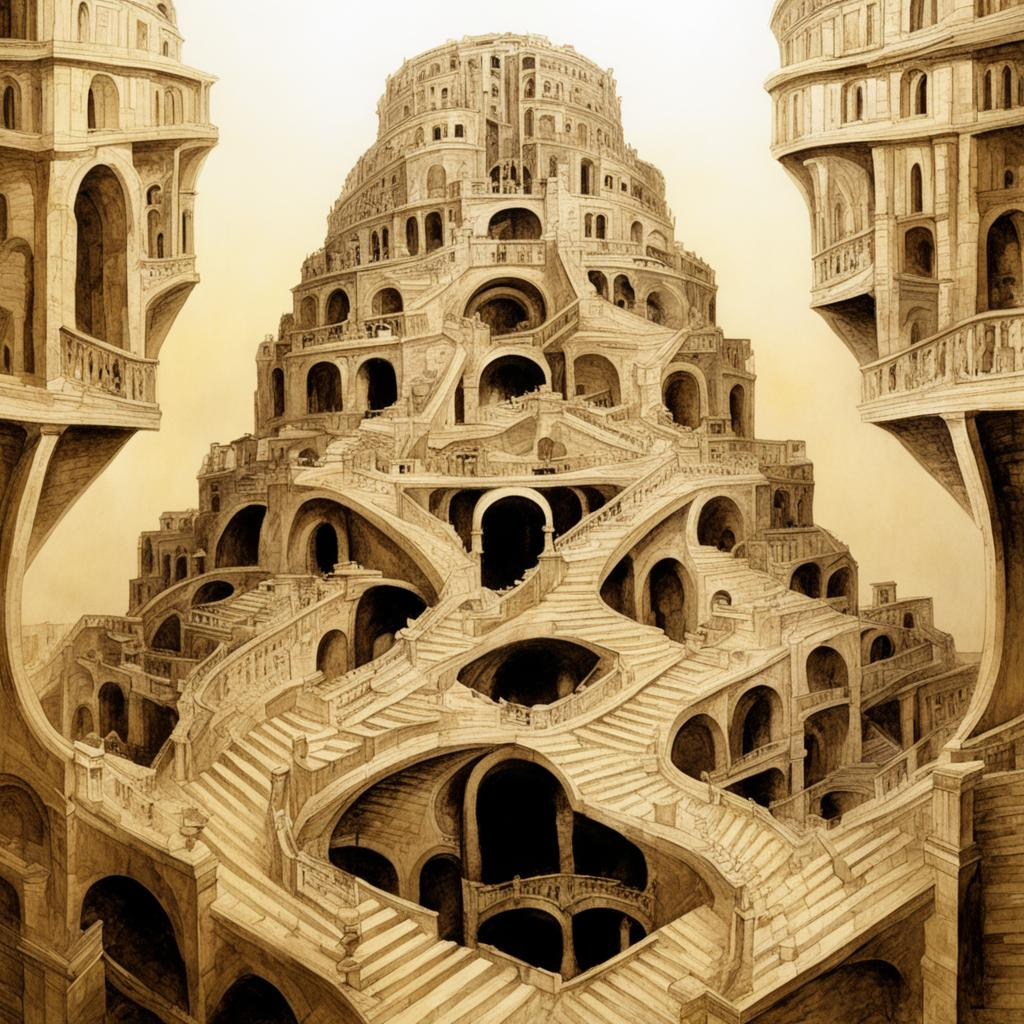)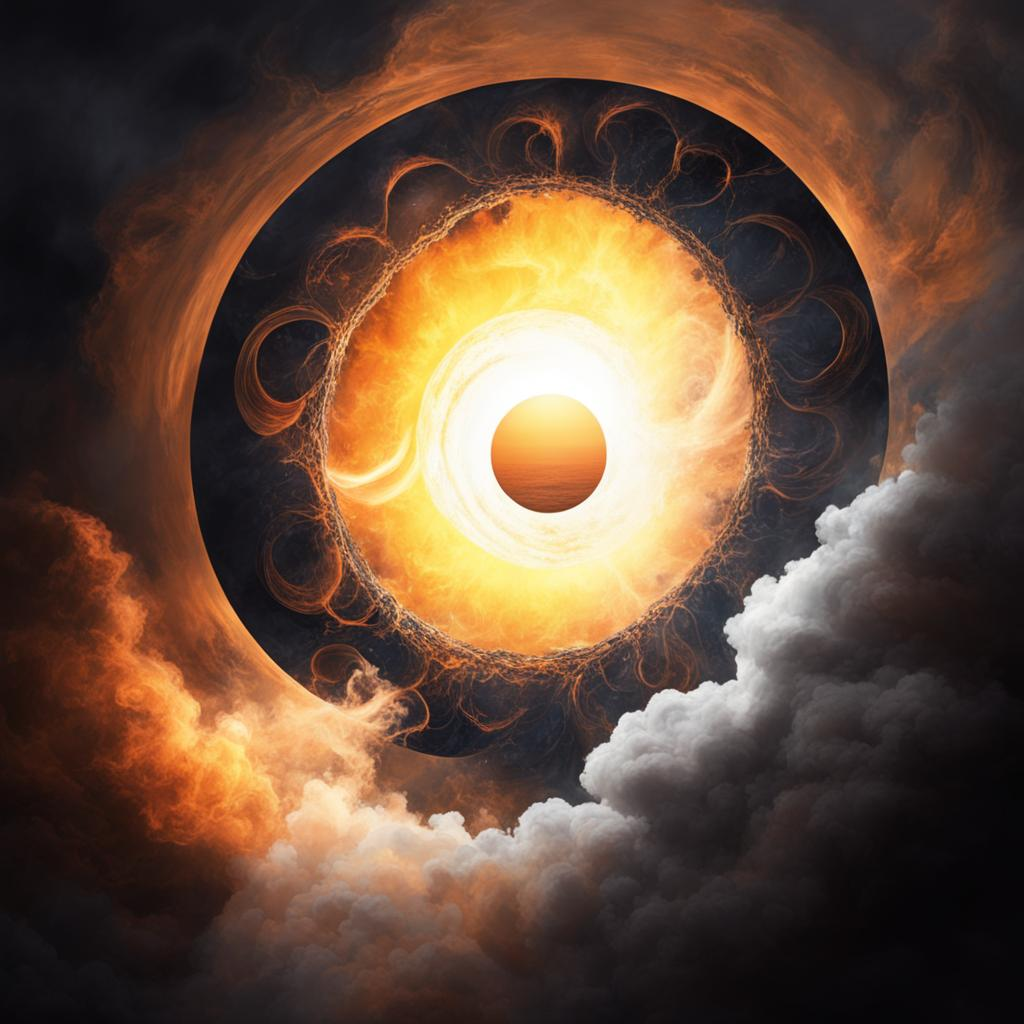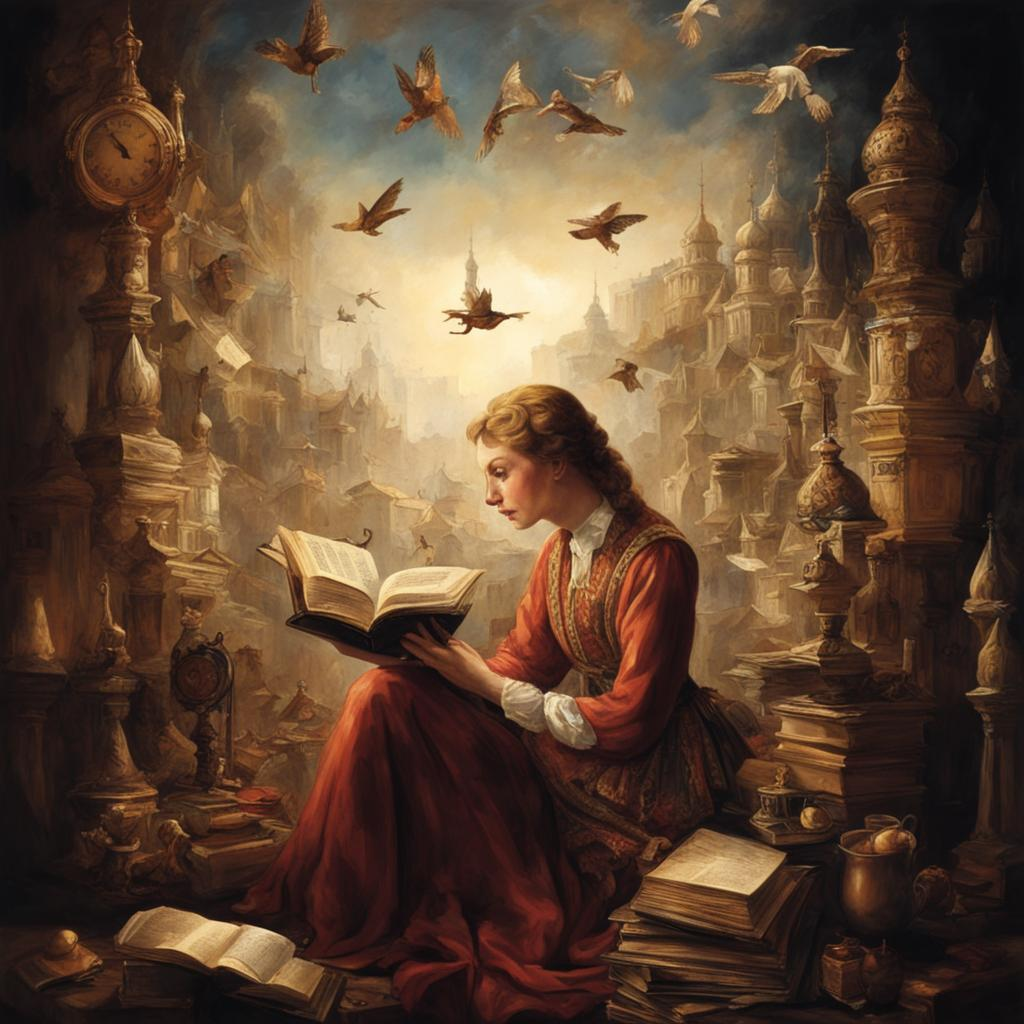